### Cell 1: Defining Key Parameters
- **`MODEL_NAME`**: Specifies the name of the model to save and load.
- **`EPOCH`**: Number of training epochs.


In [1]:
MODEL_NAME = 'resnet_100_32B_model_finetuned_s255_final.h5'
EPOCH = 100

### Cell 2: Mounting Google Drive
- Mount Google Drive to access datasets and save models. (Only needed if working on Giigle Colab, otherwise path should be changed to match structure is the cells below


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cell 3: Defining Dataset Path
- Path to the dataset ZIP file in Google Drive.


In [3]:
zip_path = '/content/drive/MyDrive/GraduateProject/archive.zip'

### Cell 4: Extracting Dataset
- In this cell we are extracting from a zip file  to a local directory for use in training and evaluation.


In [4]:
import zipfile
zipref = zipfile.ZipFile(zip_path,'r')
zipref.extractall("/content/dataset")
zipref.close()

In [5]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Cell 6: Specifying Dataset Paths
- Defining paths for authentic and tampered images in the extracted dataset.


In [6]:
authentic_path = '/content/dataset/CASIA2/Au'
tampered_path = '/content/dataset/CASIA2/Tp'

### Cell 7: Loading Image Files
- We are loading file paths for authentic and tampered images for further processing and training.


In [7]:
# Load the authentic and tempered images
authentic_images = [os.path.join(authentic_path, f) for f in os.listdir(authentic_path) if f.endswith('.jpg')]
tampered_images = [os.path.join(tampered_path, f) for f in os.listdir(tampered_path) if f.endswith('.jpg')]


### Cell 8: Labeling the Images
- **Labels**: `0` for authentic images, `1` for tampered images.
- Combine image paths and labels for training.


In [8]:
# Create the labels
y_authentic = np.zeros(len(authentic_images))
y_tampered = np.ones(len(tampered_images))
# Combine the images and labels
X = authentic_images + tampered_images
Y = np.concatenate((y_authentic, y_tampered))

### Cell 9-10: Splitting Dataset into Train, Validation, and Test Sets
- Using `train_test_split` to divide data into training, validation, and test sets with a 70-30 split initially.


In [9]:
# Split the data into training and validation sets
X_train_val_split, X_test, y_train_val_split, Y_test = train_test_split(X, Y, test_size=0.3)

In [10]:
X_train,X_val,y_train,y_val = train_test_split(X_train_val_split, y_train_val_split, test_size=0.3)

In [11]:
y_train

array([0., 1., 0., ..., 1., 0., 1.])

### Cell 12: Visualizing Class Distribution
- Visualizing the distribution of authentic and tampered images in the training dataset before augmentation.


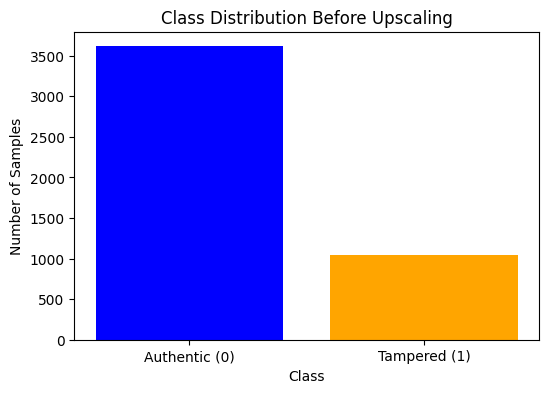

In [12]:
import matplotlib.pyplot as plt
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

#class distribution
plt.figure(figsize=(6,4))
plt.bar(['Authentic (0)', 'Tampered (1)'],
        [class_distribution.get(0,0), class_distribution.get(1,0)],
        color=['blue', 'orange'])
plt.title('Class Distribution Before Upscaling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

### Balancing the Dataset by Upsampling the Minority Class

This code  was used to address class imbalance in the training dataset by upsampling the minority class to match the size of the majority class. This caused our model to overfit, hence it was not used in the final version.

In [13]:
# from sklearn.utils import resample
# import pandas as pd

# # df for easier manipulation
# train_df = pd.DataFrame({'image_path': X_train, 'label': y_train})

# # majority and minority classes
# authentic = train_df[train_df.label == 0]
# tampered = train_df[train_df.label == 1]
# if len(authentic) > len(tampered):
#     majority_class = authentic
#     minority_class = tampered
#     majority_label = 0
#     minority_label = 1
# else:
#     majority_class = tampered
#     minority_class = authentic
#     majority_label = 1
#     minority_label = 0

# # upsampling minority class
# minority_upsampled = resample(minority_class,
#                               replace=True,  # Sample with replacement
#                               n_samples=len(majority_class),  # Match majority class
#                               random_state=42)  # For reproducibility

# train_upsampled = pd.concat([majority_class, minority_upsampled])
# train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
# X_train = train_upsampled['image_path'].tolist()
# y_train = train_upsampled['label'].values

### Data Augmentation (Images)

This was our data augmentation strategy to enhance the diversity of the training dataset using the `ImageDataGenerator` class from Keras. Augmentation was done but insignificant improvments were observed, due to which we did not include it in the final version


In [14]:
# Define the data augmentation parameters
# data_augmentation = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )
data_augmentation = ImageDataGenerator(
    brightness_range=[0.8, 1.2],  # Adjust brightness slightly
    zoom_range=0.1,  # Small zoom
    fill_mode='nearest'
)

### Cell 13: Function for Error Level Analysis (ELA)
- **ELA**: Highlights compression artifacts to detect tampered areas in images.
- Converts the image into a form that is suitable for training a cnn model.


In [15]:
# def ela_image(image, scale=255):
#     """Perform Error Level Analysis (ELA) on the image."""
#     image = image.convert('L')
#     diff = ImageChops.difference(image, image.filter(ImageFilter.FIND_EDGES))
#     diff = ImageEnhance.Brightness(diff).enhance(scale)
#     return diff.convert('RGB')
from PIL import Image, ImageChops, ImageEnhance
import io

def ela_image(image, quality=90):
    """Perform Error Level Analysis (ELA) on the image using JPEG compression artifacts."""
    # Save the original image to a temporary in-memory file with reduced quality
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)

    # Load the compressed image from the in-memory buffer
    compressed_image = Image.open(buffer)

    # Calculate the difference between the original and compressed image
    ela_image = ImageChops.difference(image.convert('RGB'), compressed_image)

    # Enhance brightness based on the maximum difference
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [16]:
def is_original_image(img_path):
    """Check if the image is an original based on its file path."""
    return '/CASIA2/Au' in img_path

### Cell 14: Data Preprocessing and Augmentation
- Preprocess images by resizing, performing ELA, and normalizing.
- Augmentation was done but insignificant improvments were observed, due to which we did not include it in the final version
- Set up data generators for training and validation.


In [17]:
def preprocess_images_generator(image_paths, labels, batch_size, input_shape):
    while True:
        for start in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[start:start + batch_size]
            batch_images = []
            batch_labels = labels[start:start + batch_size]
            for img_path in batch_paths:
                img = Image.open(img_path)
                img = img.resize(input_shape[:2])
                ela_img = ela_image(img)
                img_array = np.array(ela_img, dtype=np.float32) / 255.0
                img.close()
                # img_array = np.expand_dims(img_array, axis=0)
                # Apply data augmentation only on original
                # if is_original_image(img_path):  # Define this logic based on your dataset structure
                #     augmented_img = next(data_augmentation.flow(img_array, batch_size=1))[0]
                # else:
                #     augmented_img = img_array  # Use the image without augmentation
                batch_images.append(np.squeeze(img_array))
            yield np.array(batch_images), np.array(batch_labels)


batch_size = 32
input_shape = (224, 224, 3)

train_generator = preprocess_images_generator(X_train, y_train, batch_size, input_shape)
val_generator = preprocess_images_generator(X_val, y_val, batch_size, input_shape)
#X_train = np.array([train_generator for img_path in X_train])
#X_val = np.array([val_generator for img_path in X_val])


### Cell 15: Visualizing Preprocessed Images
- Displaying a sample of processed images to confirm preprocessing and ELA steps.


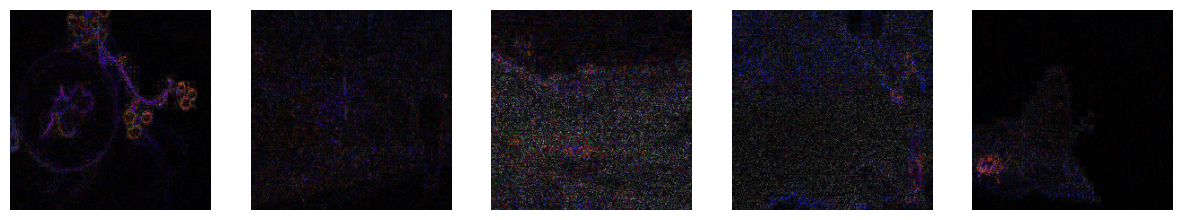

Shape of the first batch: (32, 224, 224, 3)
Pixel value range: 0.0 to 1.0


In [18]:
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance, ImageFilter
import numpy as np

#Function to visualize a batch of images
def visualize_batch(generator, num_images=5):
    # Get a batch from the generator
    batch_images, _ = next(generator)  # Retrieve a batch of processed images

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(batch_images))):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(batch_images[i])  # ELA images are typically in grayscale
        plt.axis('off')
    plt.show()

#Visualize a batch of processed images
visualize_batch(train_generator)

#Optionally, check the shape of the first batch to confirm
first_batch, _ = next(train_generator)  # Get the first batch
print("Shape of the first batch:", first_batch.shape)
print("Pixel value range:", np.min(first_batch), "to", np.max(first_batch))

### Defining the Model
- Loading a pre-trained `ResNet50` model.
- Adding custom classification layers tailored to image forgery detection task.


In [19]:
import numpy as np
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

#Load the VGG16 model with pre-trained weights, exclude top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

#Add custom layers for the classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replaces Flatten for better performance with new basemodel resnet50
x = BatchNormalization()(x)      # batch normalization
x = Dense(512, activation='relu')(x)  # more capacity
x = Dropout(0.75)(x)                  # 0.25 weak regularization dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) #0.5 stron regularization
# x = base_model.output
# x = Flatten()(x)  # VGG-16 typically uses Flatten instead of GlobalAveragePooling
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,776,577 (94.52 MB)

 Trainable params: 1,184,769 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

### Defining Learning Rate Scheduler and Early Stopping
- **Learning Rate Scheduler**: Adjusts the learning rate dynamically.
- **Early Stopping**: Halts training when validation performance stops improving. We opted to not use it in our final output.


In [21]:
#decaying learning rate
def lr_decay(epoch, lr):
    return lr * 0.95 if epoch > 10 else lr


# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # later we will change this to "'val_accuracy'" to test
    patience=10,
    restore_best_weights=True  # restores the weights of the best epoch
)
learning_rate_scheduler = LearningRateScheduler(lr_decay)

### Custom Metrics specific to Task and Model Compilation
- Defining custom metrics of F1-score, precision, and recall.
- Compiling the model with `binary_crossentropy` loss and relevant metrics.


In [22]:
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, tf.float32)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(), f1_m])
#Fit the model using the generators
batch_size = 32  # Adjust based on your available memory

hist = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    epochs=EPOCH,
    #callbacks=[learning_rate_scheduler, early_stopping]
)

Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 90s 495ms/step - accuracy: 0.7660 - auc: 0.6824 - f1_m: 2.8219 - loss: 0.5254 - val_accuracy: 0.8004 - val_auc: 0.7553 - val_f1_m: 0.0000e+00 - val_loss: 0.6882
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 58s 404ms/step - accuracy: 0.7782 - auc: 0.7773 - f1_m: 3.4575 - loss: 0.4523 - val_accuracy: 0.7998 - val_auc: 0.7830 - val_f1_m: 0.0000e+00 - val_loss: 0.5142
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 375ms/step - accuracy: 0.7788 - auc: 0.7903 - f1_m: 4.0518 - loss: 0.4426 - val_accuracy: 0.8013 - val_auc: 0.7904 - val_f1_m: 0.0000e+00 - val_loss: 0.4353
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 56s 391ms/step - accuracy: 0.7776 - auc: 0.8038 - f1_m: 4.2292 - loss: 0.4301 - val_accuracy: 0.7967 - val_auc: 0.7970 - val_f1_m: 3.4728 - val_loss: 0.4171
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 377ms/step - accuracy: 0.7847 - auc: 0.7968 - f1_m: 4.6485 - loss: 0.4394 - val_accuracy: 0.8039 - val_auc: 0.8011 - val_f1_m: 5.6837 - val_loss: 0.414

### Saving the Model
- Save the trained model to the specified path for future evaluation and use.


In [23]:
model.save(MODEL_NAME)

### Training History Visualization
- Ploting the training and validation loss and accuracy to analyze model performance on the dataset.


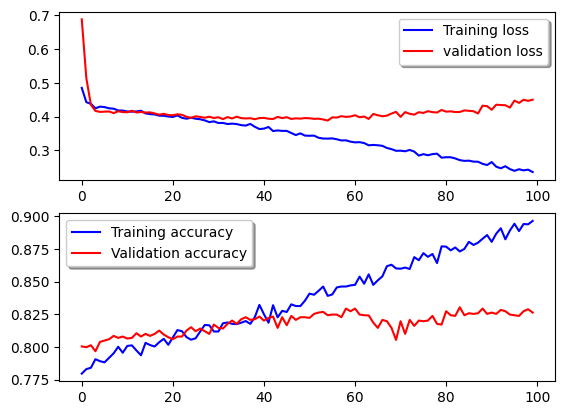

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Loading the Model
- Loading the saved model for evaluation or further training.


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(MODEL_NAME)

loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,776,579 (94.52 MB)

 Trainable params: 1,184,769 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

 Optimizer params: 2 (12.00 B)

### Test Generator
- Creating a generator for the test dataset to evaluate model performance.


In [ ]:
test_generator  = preprocess_images_generator(X_test, Y_test, batch_size, input_shape)
test_steps = len(X_test) // batch_size
print(test_steps)

89


In [ ]:
print(hist.history)

{'accuracy': [0.7704953551292419, 0.7932078838348389, 0.795258641242981, 0.7925589680671692, 0.7936404943466187, 0.7983993291854858, 0.8007786870002747, 0.7994808554649353, 0.7999134659767151, 0.801643967628479, 0.8042396903038025, 0.8061864376068115, 0.8100800514221191, 0.8031581044197083, 0.8085658550262451, 0.8061864376068115, 0.8044559955596924, 0.8128920793533325, 0.806835412979126, 0.8141899108886719, 0.8081332445144653, 0.8159204125404358, 0.8128920793533325, 0.8187324404716492, 0.810296356678009, 0.8083495497703552, 0.8126757740974426, 0.8180835247039795, 0.8131083846092224, 0.8170019388198853, 0.8131083846092224, 0.8204628825187683, 0.8180835247039795, 0.8247891068458557, 0.8150551319122314, 0.8247891068458557, 0.8239238858222961, 0.8232749104499817, 0.8213281631469727, 0.8206791877746582, 0.8258706331253052, 0.8288989663124084, 0.8319272994995117, 0.8291152715682983, 0.8204628825187683, 0.8314946889877319, 0.8310620784759521, 0.8310620784759521, 0.8321436047554016, 0.83560460

In [ ]:
import json

# Save history to a JSON file
with open('history.json', 'w') as f:
    json.dump(hist.history, f)

    # Load history from JSON file
with open('history.json', 'r') as f:
    loaded_history = json.load(f)

# Now you can access the history as a dictionary
print(loaded_history['loss'])
print(loaded_history['val_loss'])

[0.4860582649707794, 0.42800623178482056, 0.42464861273765564, 0.4195820689201355, 0.4166221618652344, 0.41683951020240784, 0.41242510080337524, 0.4048512279987335, 0.4091240465641022, 0.40765470266342163, 0.41009625792503357, 0.4046421945095062, 0.39843472838401794, 0.39801350235939026, 0.3993220925331116, 0.4005196690559387, 0.40016308426856995, 0.395507276058197, 0.3973890244960785, 0.395106703042984, 0.3883691430091858, 0.391902893781662, 0.3879879415035248, 0.389198899269104, 0.39210236072540283, 0.38626033067703247, 0.38937851786613464, 0.38154348731040955, 0.3841436505317688, 0.3811718225479126, 0.3818134367465973, 0.37827908992767334, 0.3750497102737427, 0.3730298578739166, 0.37693580985069275, 0.3722445070743561, 0.36933842301368713, 0.37174391746520996, 0.36889076232910156, 0.36855292320251465, 0.3679843544960022, 0.3641006350517273, 0.359508752822876, 0.3610483407974243, 0.36362308263778687, 0.3569904565811157, 0.3586876392364502, 0.3533361852169037, 0.3520537316799164, 0.34

### Performance Visualization (Detailed)
- Plot loss, accuracy, AUC-ROC, and F1 score trends over epochs.


AUC metrics not found in history. Skipping AUC plot.


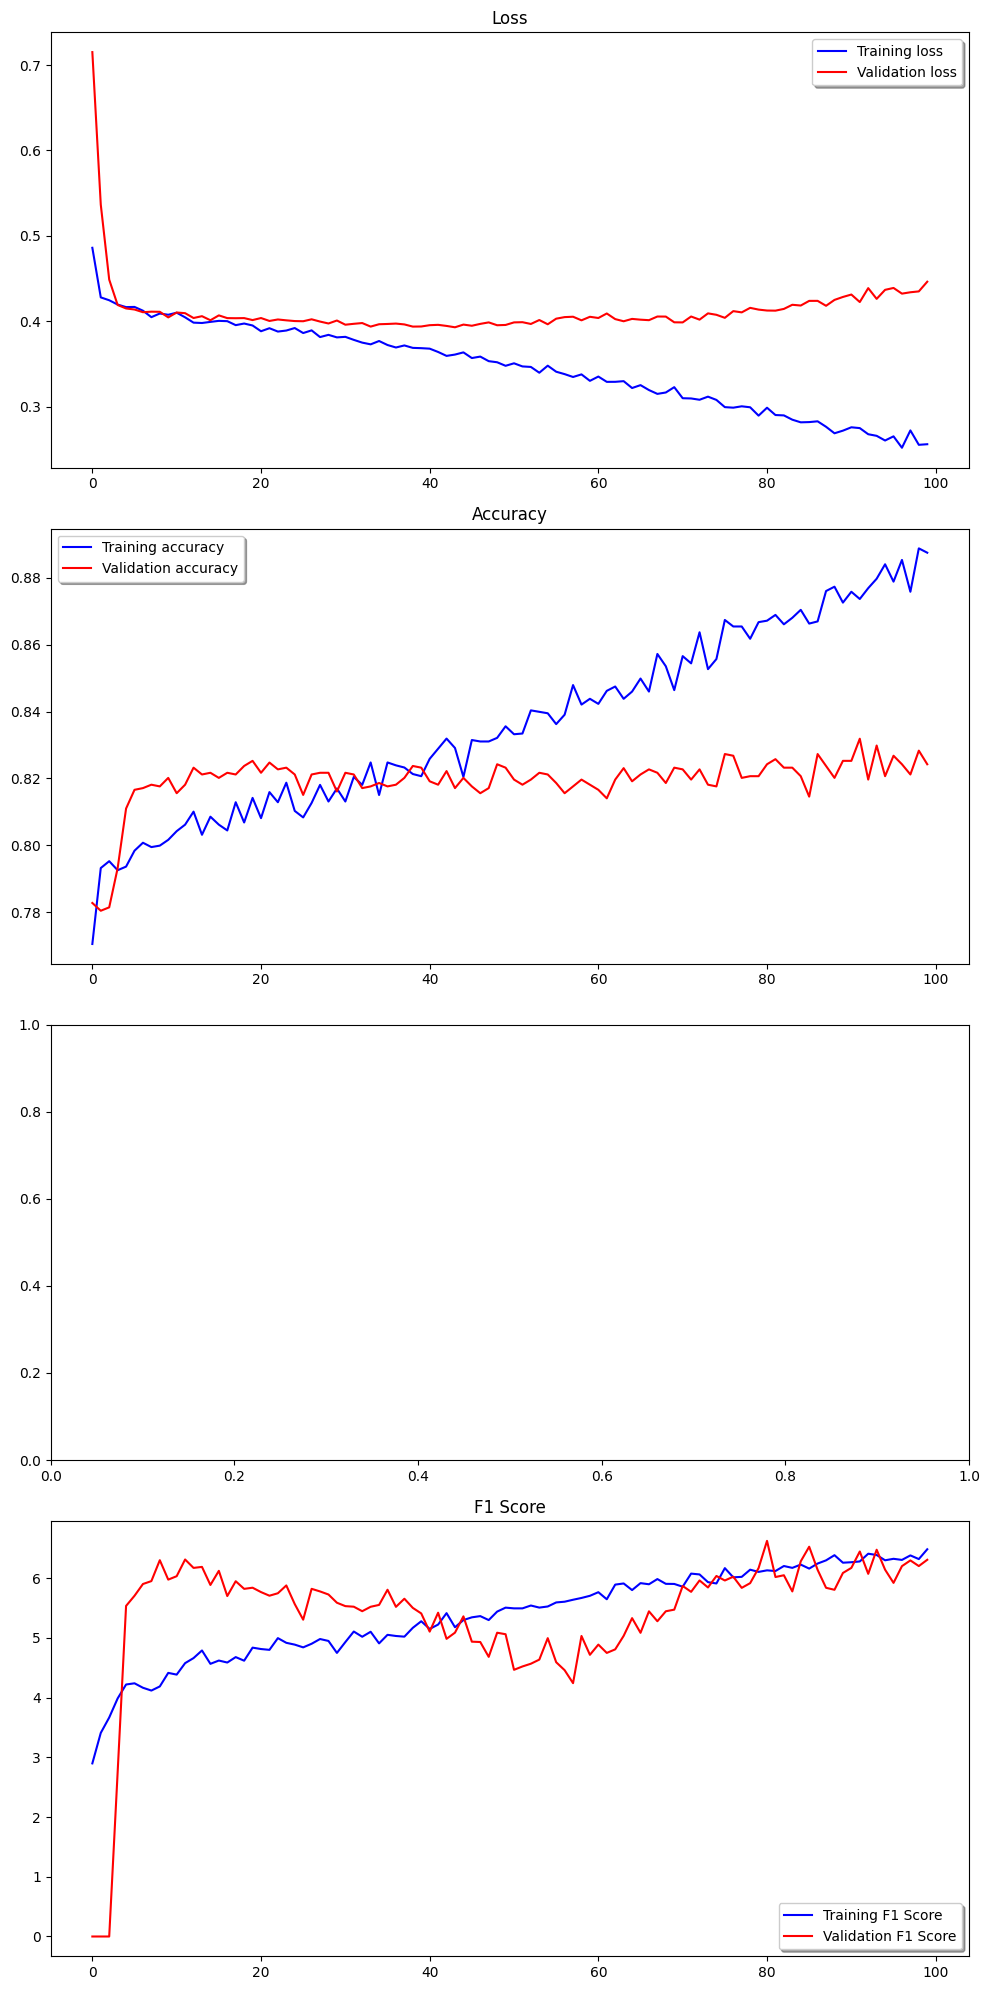

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10, 20))  # Adjust to have 4 subplots

# Plot Training and Validation Loss
ax[0].plot(loaded_history['loss'], color='b', label="Training loss")
ax[0].plot(loaded_history['val_loss'], color='r', label="Validation loss")
ax[0].set_title('Loss')
ax[0].legend(loc='best', shadow=True)

# Plot Training and Validation Accuracy
ax[1].plot(loaded_history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(loaded_history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].legend(loc='best', shadow=True)

# Check if 'auc_6' and 'val_auc_6' are in loaded_history
if 'auc_6' in loaded_history and 'val_auc_6' in loaded_history:
    # Plot Training and Validation AUC-ROC
    ax[2].plot(loaded_history['auc_6'], color='b', label="Training AUC-ROC")
    ax[2].plot(loaded_history['val_auc_6'], color='r', label="Validation AUC-ROC")
    ax[2].set_title('AUC-ROC')
    ax[2].legend(loc='best', shadow=True)
else:
    print("AUC metrics not found in history. Skipping AUC plot.")

# Check if 'f1_m' and 'val_f1_m' are in loaded_history
if 'f1_m' in loaded_history and 'val_f1_m' in loaded_history:
    # Plot Training and Validation F1 Score
    ax[3].plot(loaded_history['f1_m'], color='b', label="Training F1 Score")
    ax[3].plot(loaded_history['val_f1_m'], color='r', label="Validation F1 Score")
    ax[3].set_title('F1 Score')
    ax[3].legend(loc='best', shadow=True)
else:
    print("F1 Score metrics not found in history. Skipping F1 Score plot.")

plt.tight_layout()
plt.show()

### Generating and Visualizing the Confusion Matrix
- Evaluating the model predictions on the validation/test set.
- Plotting the confusion matrix and displaying classification report for detailed metrics.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━

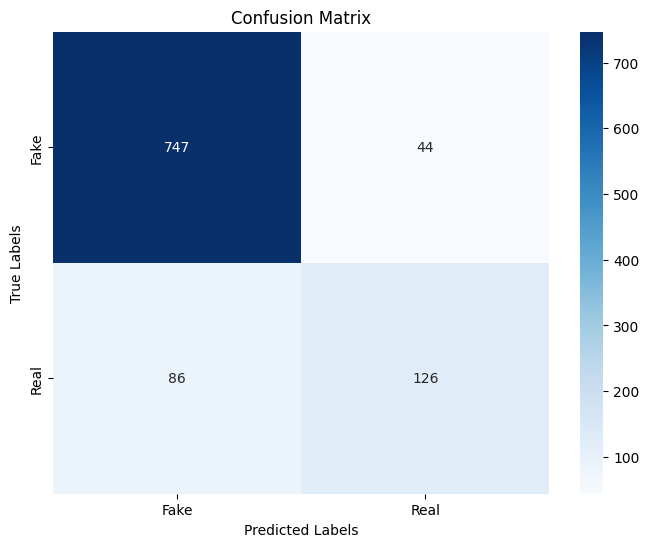

Classification Report:
               precision    recall  f1-score   support

        Fake       0.90      0.94      0.92       791
        Real       0.74      0.59      0.66       212

    accuracy                           0.87      1003
   macro avg       0.82      0.77      0.79      1003
weighted avg       0.86      0.87      0.86      1003



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Step 1: Get predictions from the model
def get_predictions(generator, model,max_images=1000):
    y_true = []
    y_pred = []

    for images, labels in generator:
        preds = model.predict(images)
        preds_binary = (preds > 0.5).astype(int)  # Binary classification threshold
        y_true.extend(labels)
        y_pred.extend(preds_binary)
        if len(y_true) >= max_images:
            break
    return np.array(y_true),np.array(y_pred)

MODEL_NAME = '/content/drive/MyDrive/resnet_100_32B_model_finetuned_s255.h5'
loaded_model = load_model(MODEL_NAME)

y_true, y_pred = get_predictions(val_generator,loaded_model)

# Step 2: Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Step 3: Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

### Cell 26: Closing Thoughts
- Summarize here


In [ ]:
#TODO:
#Test DataSet
#Model.predict
#Change intial learning rate
#Draw graphs
# Data Augmentation (Class Balancing)